# **Project Description** (Group#13)

# **1. Project Title**: Predicting Machine Failure and Failure Type in a Manufacturing Plant

# **2. Project Objective**: 
To build machine learning models that can predict when a machine is likely to fail and what type of failure it is in a manufacturing plant, based on historical sensor data and machine features.

# **3. Dataset**: 
The dataset contains information on 10,000 data points collected from sensors in the machines used in the manufacturing process. Each row represents a data point and each column represents a feature such as air temperature, process temperature, rotational speed, torque, tool wear, and machine failure. The target variable for the first model is whether or not a machine failure will occur, and for the second model, it is the type of failure that may occur (i.e. tool wear failure, high temperature deviation failure, power failure, etc.).

# **Deliverables:**

# ***1. Data Exploration and Preprocessing:***

### All necessary imports

In [155]:
# Importing the required libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
# SVM Model
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
# Neural Network Model
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


# For checking normal distribution of the dataset
from scipy.stats import jarque_bera
from numpy.random import randn

# For checking linearity of the dataset
from statsmodels.stats.stattools import durbin_watson

#for dealing with class imbalance
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

## **a. Load the dataset and examine the columns, their data types, and any missing values.**

In [156]:
!wget 'https://archive.ics.uci.edu/ml/machine-learning-databases/00601/ai4i2020.csv'

--2023-05-22 05:22:44--  https://archive.ics.uci.edu/ml/machine-learning-databases/00601/ai4i2020.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 522048 (510K) [application/x-httpd-php]
Saving to: ‘ai4i2020.csv.3’

ai4i2020.csv.3      100%[===================>] 509.81K  1.46MB/s    in 0.3s    

2023-05-22 05:22:44 (1.46 MB/s) - ‘ai4i2020.csv.3’ saved [522048/522048]



In [157]:
# Load the dataset
data = pd.read_csv('ai4i2020.csv')
# display dataset
data.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


### Reasons behind selecting this Dataset:


*   This dataset contains a diverse set of sensor data collected from industrial machines over time, along with information on whether or not the machine failed and what type of failure occurred. This makes it well-suited for building predictive models that can detect when a machine is likely to fail and what type of failure is most likely to occur.
*   This dataset contains over 10,000 rows and 14 columns, which provides a sufficient amount of data for training and testing machine learning models.

*   This dataset is freely available and has been widely used in research and industry, which means that there are already established benchmarks and best practices for working with this dataset. This makes it easier to compare results and evaluate the effectiveness of different machine learning models.

*   This dataset was generated from a real manufacturing process, making it more applicable to real-world scenarios. This means that the insights and predictions generated from this dataset may be more valuable and relevant for industries that deal with machines and maintenance.
*   This dataset includes a wide range of sensor data, as well as operational and maintenance data, which can help build a more comprehensive understanding of the factors that contribute to machine failure. This can lead to better models and more accurate predictions.


Overall, the AI4I 2020 Predictive Maintenance Dataset is a well-suited and widely used dataset for building predictive models to detect machine failure, making it a strong choice for this problem.





In [158]:
# Checking shape of the dataset
print("Number of instances & columns: ", data.shape)


Number of instances & columns:  (10000, 14)


In [159]:
# Examine the columns
print("Columns present in the dataset:")
print(data.columns)

Columns present in the dataset:
Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')


### Dataset Explanation:
The dataset consists of **10,000** data points stored as rows with **14** features in columns:


1.   **UID**: unique identifier ranging from 1 to 10000

2.   **Product ID**: consisting of a letter L, M, or H in conjugation with a unique number

3.   **Type**: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%)

4.   **Air temperature [K]**: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K

5.   **Process temperature [K]**: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K

6.   **Rotational speed [rpm]**: calculated from a power of 2860 W, overlaid with a normally distributed noise

7.   **Torque [Nm]**: torque values are normally distributed around 40 Nm with a Ïƒ = 10 Nm and no negative values. 

8.   **Tool wear [min]**: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process

9.  **Machine failure**: The label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true

The Machine failure consists of 5 independent failure modes:

10.    **TWF** (tool wear failure): the tool will be replaced of fail at a randomly selected tool wear time between 200 to 240 mins


11.    **HDF** (heat dissipation failure): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the tool's rotational speed is below 1380 rpm.


12.   **PWF** (power failure): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails.


13.   **OSF** (overstrain failure): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain.


14.   **RNF** (random failures): each process has a chance of 0,1 % to fail regardless of its process parameters.



In [160]:
# Examine data types
print("\nData types of different columns in the dataset:")
print(data.dtypes)


Data types of different columns in the dataset:
UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object


In [161]:
# Examine the columns and their data types
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In this code, we are using nested np.where statements to check the presence of failure types in the individual columns. If a failure type is found, the corresponding value (1, 2, 3, 4, or 5) is assigned to the new 'Failure Type' column. If no failure type is found, a value of 0 is assigned.

In [162]:
# Create a new column for failure type
data['Failure Type'] = np.where(data['TWF'] == 1, 1,
                                     np.where(data['HDF'] == 1, 2,
                                              np.where(data['PWF'] == 1, 3,
                                                       np.where(data['OSF'] == 1, 4,
                                                                np.where(data['RNF'] == 1, 5, 0)))))

# Drop the individual failure type columns
data.drop(['TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1, inplace=True)


### **Quantitative Visualizations**

In [163]:
for col in data[['Type','Machine failure']]:
    print(data[col].value_counts()) 
    print("****"*8)

L    6000
M    2997
H    1003
Name: Type, dtype: int64
********************************
0    9661
1     339
Name: Machine failure, dtype: int64
********************************


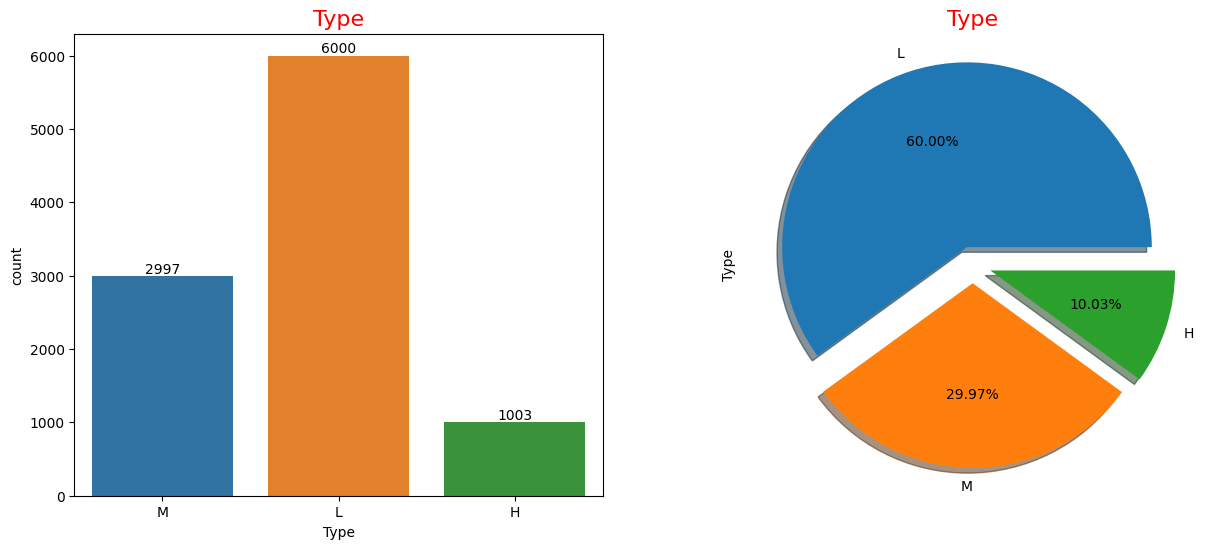

In [164]:
ax = plt.figure(figsize=(15,6))
ax = plt.subplot(1,2,1)
ax = sns.countplot(x='Type', data=data)
ax.bar_label(ax.containers[0])
plt.title("Type", fontsize=16,color='Red')
ax =plt.subplot(1,2,2)
ax=data['Type'].value_counts().plot.pie(explode=[0.1, 0.1,0.1],autopct='%1.2f%%',shadow=True);
ax.set_title(label = "Type", fontsize = 16,color='Red');

In [165]:
# Count the number of instances in each class
class_counts = data['Machine failure'].value_counts()

# Print the class counts
print("Class 0 (no failure):", class_counts[0])
print("Class 1 (failure):", class_counts[1])

# Calculate the class balance
class_balance = class_counts[1] / (class_counts[0] + class_counts[1])

print("Class balance: {:.2f}%".format(class_balance * 100))


Class 0 (no failure): 9661
Class 1 (failure): 339
Class balance: 3.39%


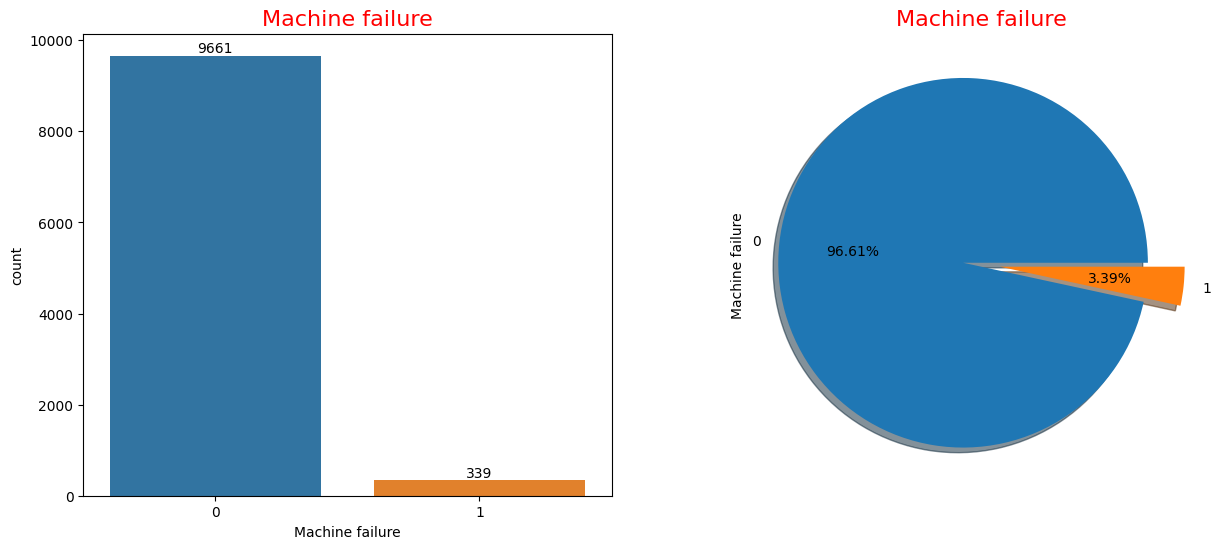

In [166]:
ax = plt.figure(figsize=(15,6))
ax = plt.subplot(1,2,1)
ax = sns.countplot(x='Machine failure', data=data)
ax.bar_label(ax.containers[0])
plt.title("Machine failure", fontsize=16,color='Red')
ax =plt.subplot(1,2,2)
ax=data['Machine failure'].value_counts().plot.pie(explode=[0.1, 0.1],autopct='%1.2f%%',shadow=True);
ax.set_title(label = "Machine failure", fontsize = 16,color='Red');

### **Relational Visualizations**

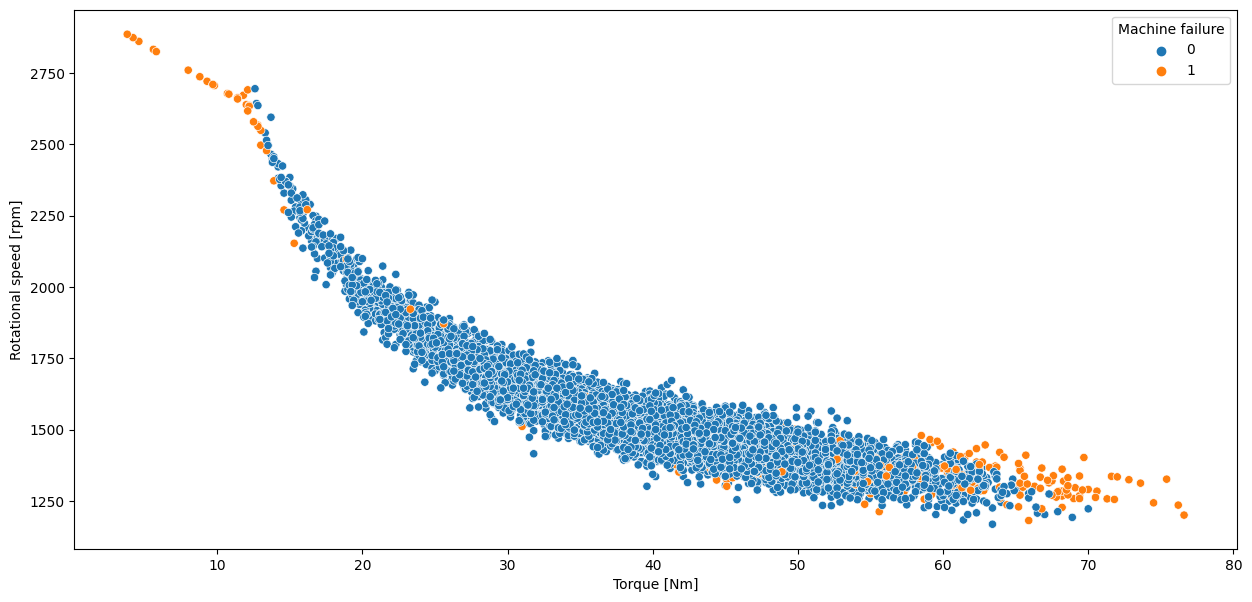

In [167]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=data, x="Torque [Nm]", y="Rotational speed [rpm]", hue="Machine failure",palette="tab10");

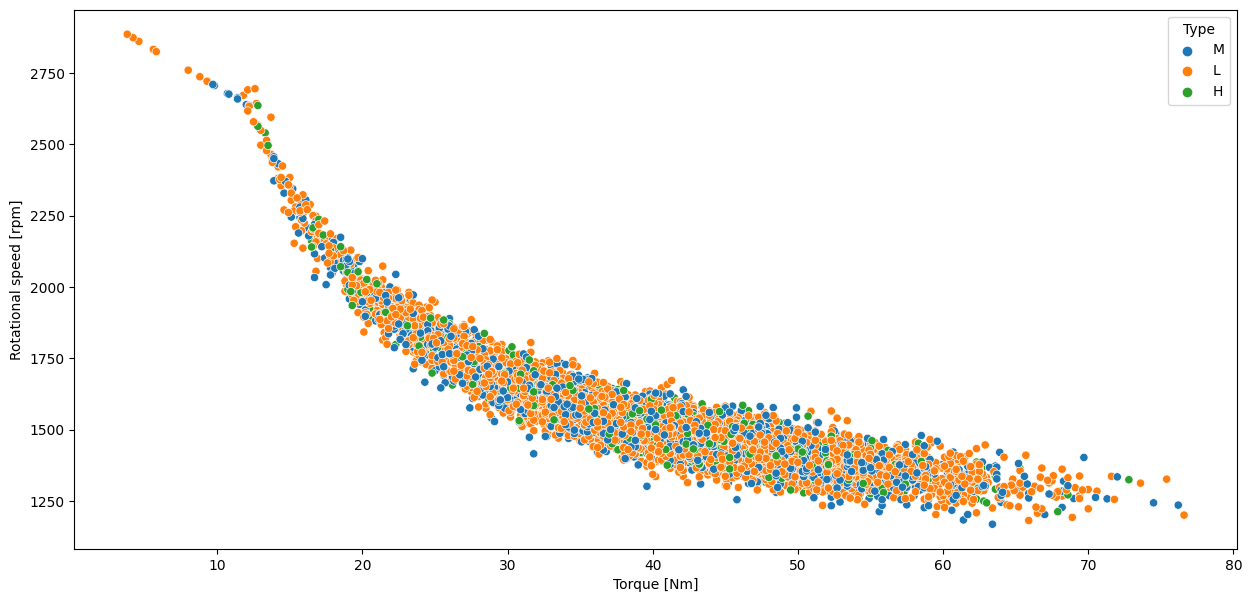

In [168]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=data, x="Torque [Nm]", y="Rotational speed [rpm]", hue="Type",palette="tab10");

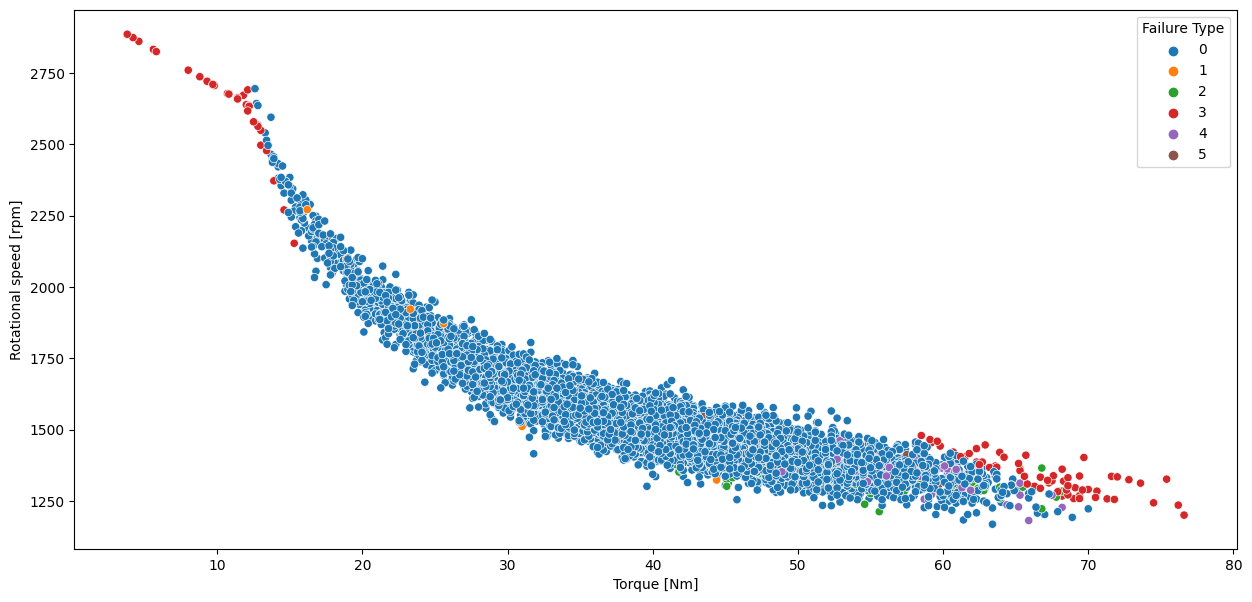

In [169]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=data, x="Torque [Nm]", y="Rotational speed [rpm]", hue="Failure Type",palette="tab10");

### **Missing Values**

In [170]:
# Check for missing values
print("\nAny missing values in any of the columns:\n")
print(data.isnull())
print(data.isnull().sum())


Any missing values in any of the columns:

        UDI  Product ID   Type  Air temperature [K]  Process temperature [K]  \
0     False       False  False                False                    False   
1     False       False  False                False                    False   
2     False       False  False                False                    False   
3     False       False  False                False                    False   
4     False       False  False                False                    False   
...     ...         ...    ...                  ...                      ...   
9995  False       False  False                False                    False   
9996  False       False  False                False                    False   
9997  False       False  False                False                    False   
9998  False       False  False                False                    False   
9999  False       False  False                False                    False

In [171]:
# display NaN in each column
data.isna().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
Failure Type               0
dtype: int64

In [172]:
#Dropping unnecessary column
data = data.drop(['UDI', 'Product ID'],axis=1)    #these columns are of no use as they are not a deciding factor to our Target

In [173]:
# Examine the columns and their data types
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     10000 non-null  object 
 1   Air temperature [K]      10000 non-null  float64
 2   Process temperature [K]  10000 non-null  float64
 3   Rotational speed [rpm]   10000 non-null  int64  
 4   Torque [Nm]              10000 non-null  float64
 5   Tool wear [min]          10000 non-null  int64  
 6   Machine failure          10000 non-null  int64  
 7   Failure Type             10000 non-null  int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 625.1+ KB
None


### **Exploratory Data Analysis**

Maximum value: 304.5
Minimum value: 295.3


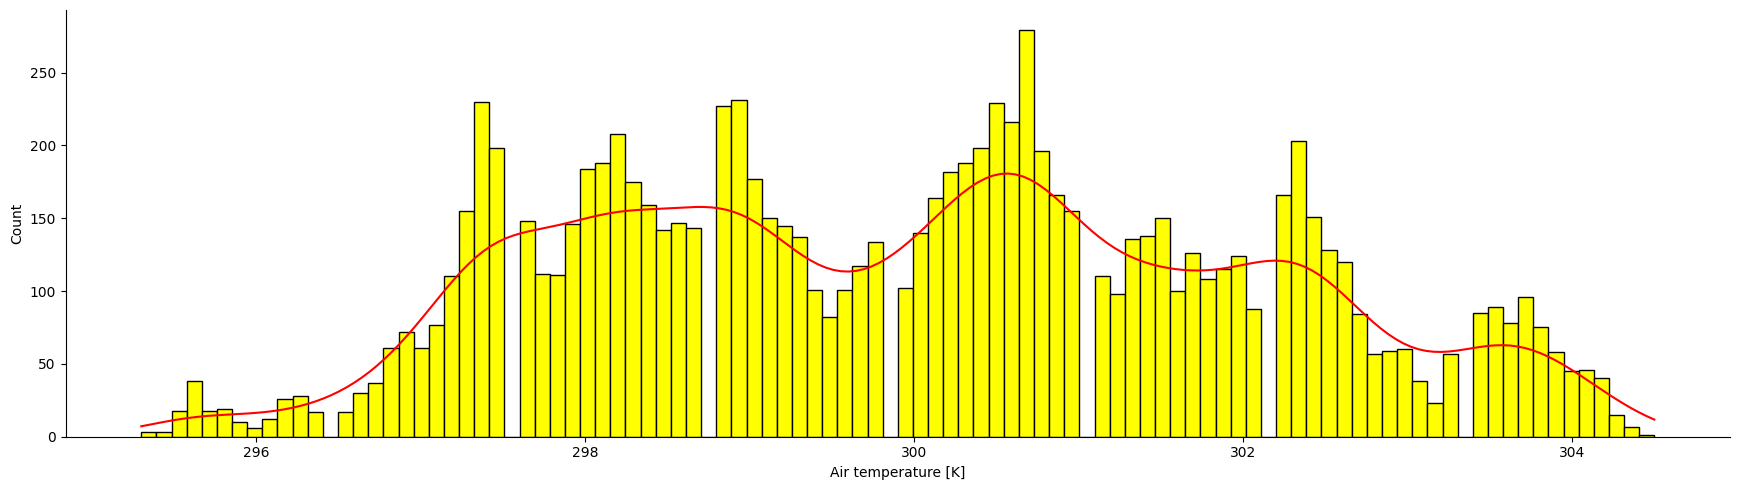

In [174]:
sns.displot(data=data, x="Air temperature [K]", kde=True, bins = 100,color = "red", facecolor = "yellow",height = 5, aspect = 3.5);

print("Maximum value:",  data['Air temperature [K]'].max())
print("Minimum value:",  data['Air temperature [K]'].min())

Maximum value: 313.8
Minimum value: 305.7


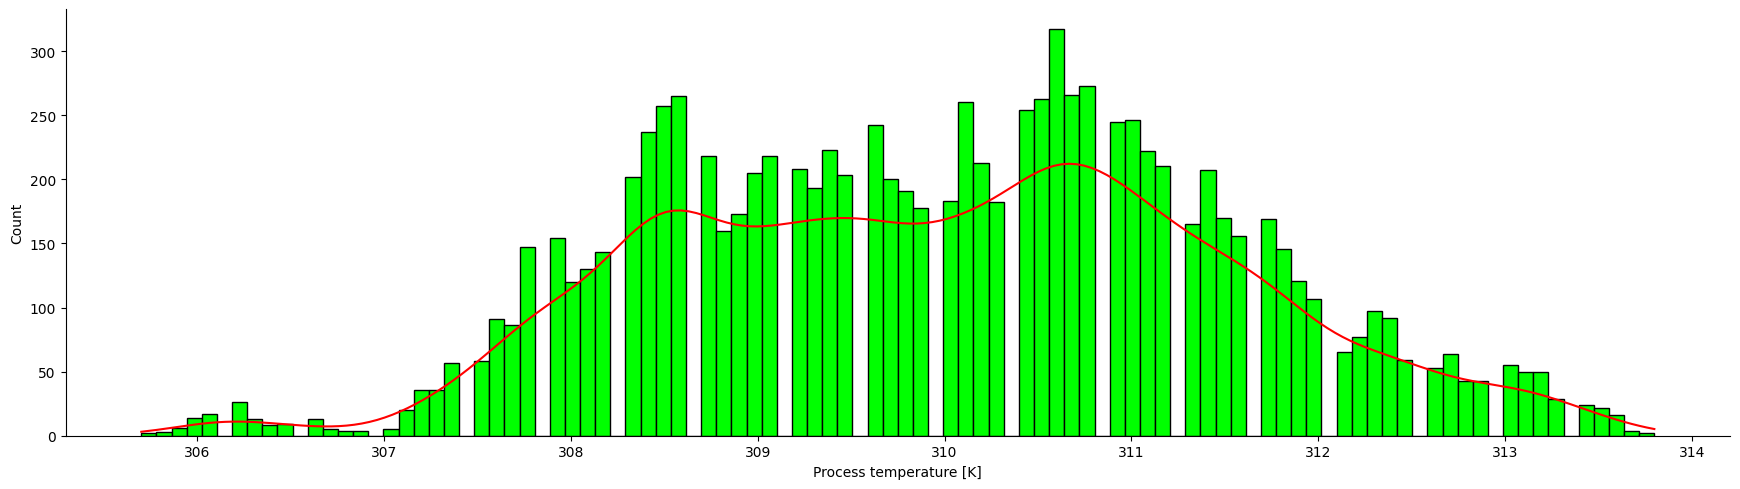

In [175]:
sns.displot(data=data, x="Process temperature [K]", kde=True, bins = 100,color = "red", facecolor = "lime",height = 5, aspect = 3.5);

print("Maximum value:",  data['Process temperature [K]'].max())
print("Minimum value:",  data['Process temperature [K]'].min())

Maximum value: 2886
Minimum value: 1168


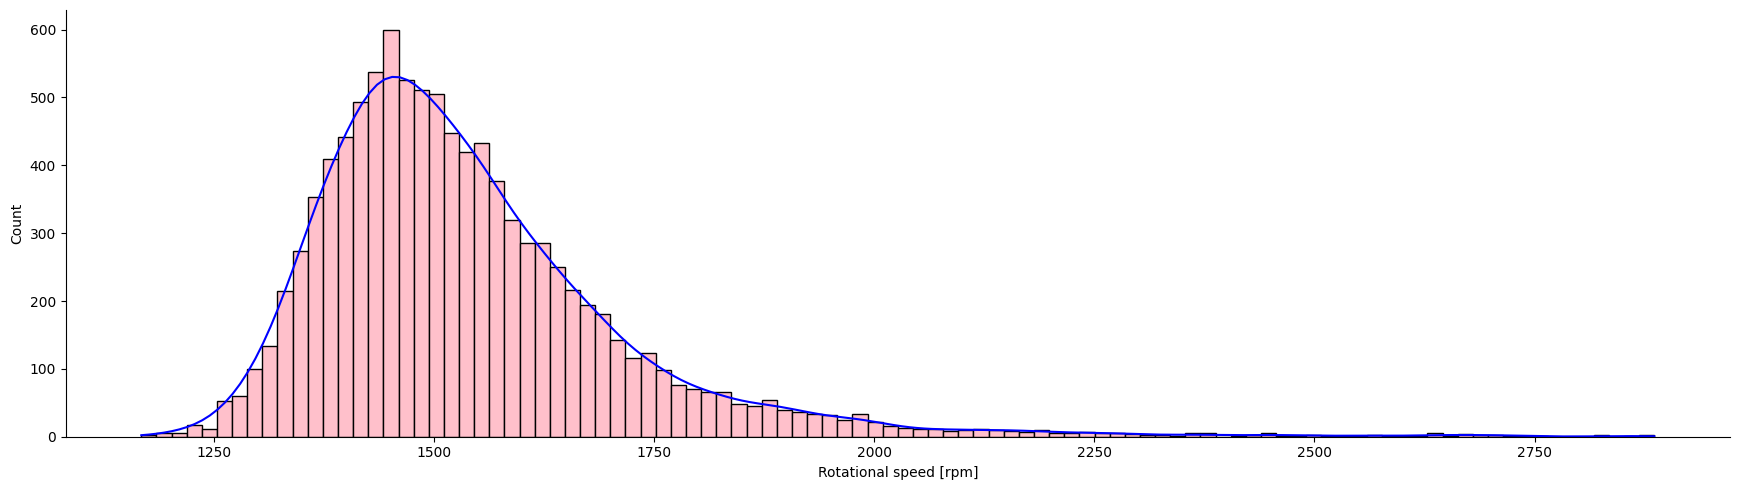

In [176]:
sns.displot(data=data, x="Rotational speed [rpm]", kde=True, bins = 100,color = "blue", facecolor = "pink",height = 5, aspect = 3.5);

print("Maximum value:",  data['Rotational speed [rpm]'].max())
print("Minimum value:",  data['Rotational speed [rpm]'].min())

Maximum value: 76.6
Minimum value: 3.8


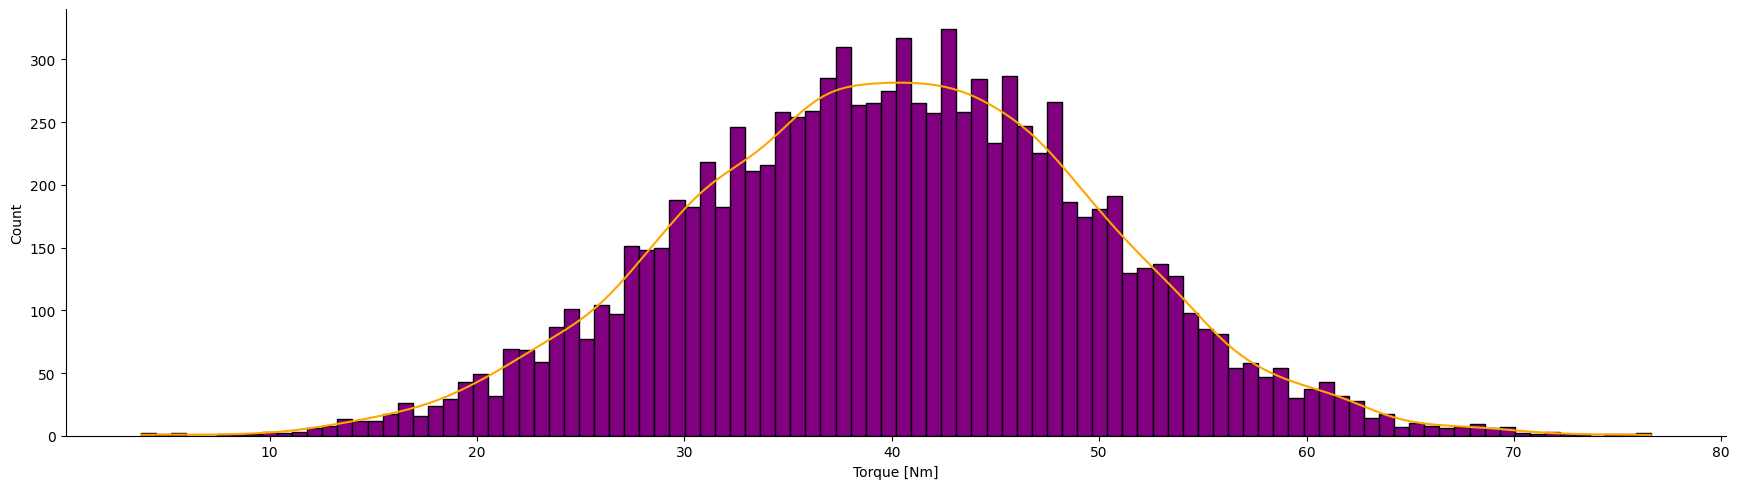

In [177]:
sns.displot(data=data, x="Torque [Nm]", kde=True, bins = 100,color = "orange", facecolor = "purple",height = 5, aspect = 3.5);

print("Maximum value:",  data['Torque [Nm]'].max())
print("Minimum value:",  data['Torque [Nm]'].min())

Maximum value: 253
Minimum value: 0


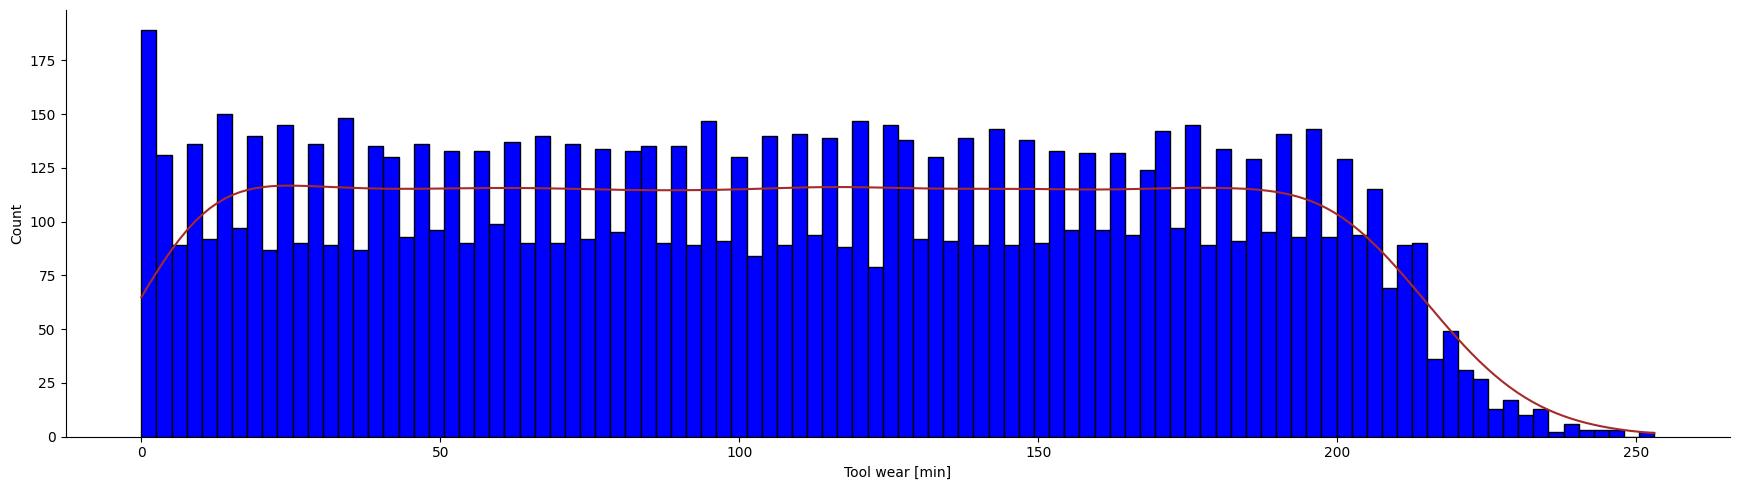

In [178]:
sns.displot(data=data, x="Tool wear [min]", kde=True, bins = 100,color = "brown", facecolor = "blue",height = 5, aspect = 3.5);

print("Maximum value:",  data['Tool wear [min]'].max())
print("Minimum value:",  data['Tool wear [min]'].min())

# **b. Check for any outliers and remove them if necessary.**

<ipython-input-179-517ad27a7eb0>:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = data.quantile(0.25)
<ipython-input-179-517ad27a7eb0>:3: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = data.quantile(0.75)
<ipython-input-179-517ad27a7eb0>:11: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  data_no_outliers = data[~((data < lower_bound) | (data > upper_bound)).any(axis=1)]




Box Plots for Original Data




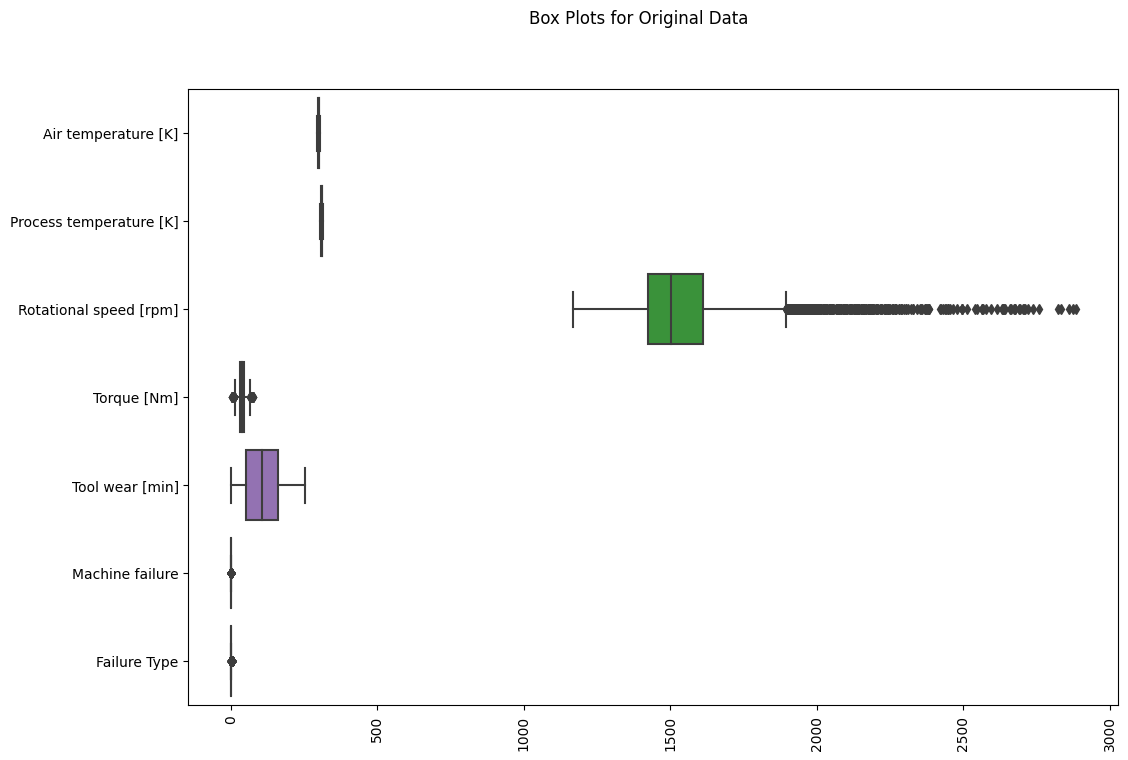

In [179]:
# Calculate the IQR (Inter Quartile Range)
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
data_no_outliers = data[~((data < lower_bound) | (data > upper_bound)).any(axis=1)]

print("\n\nBox Plots for Original Data\n\n")
# Create box plots for original data
plt.figure(figsize=(12, 8))
plt.suptitle("Box Plots for Original Data")
sns.boxplot(data=data, orient='h')
plt.xticks(rotation=90)
plt.show()



Box Plots for Data without Outliers




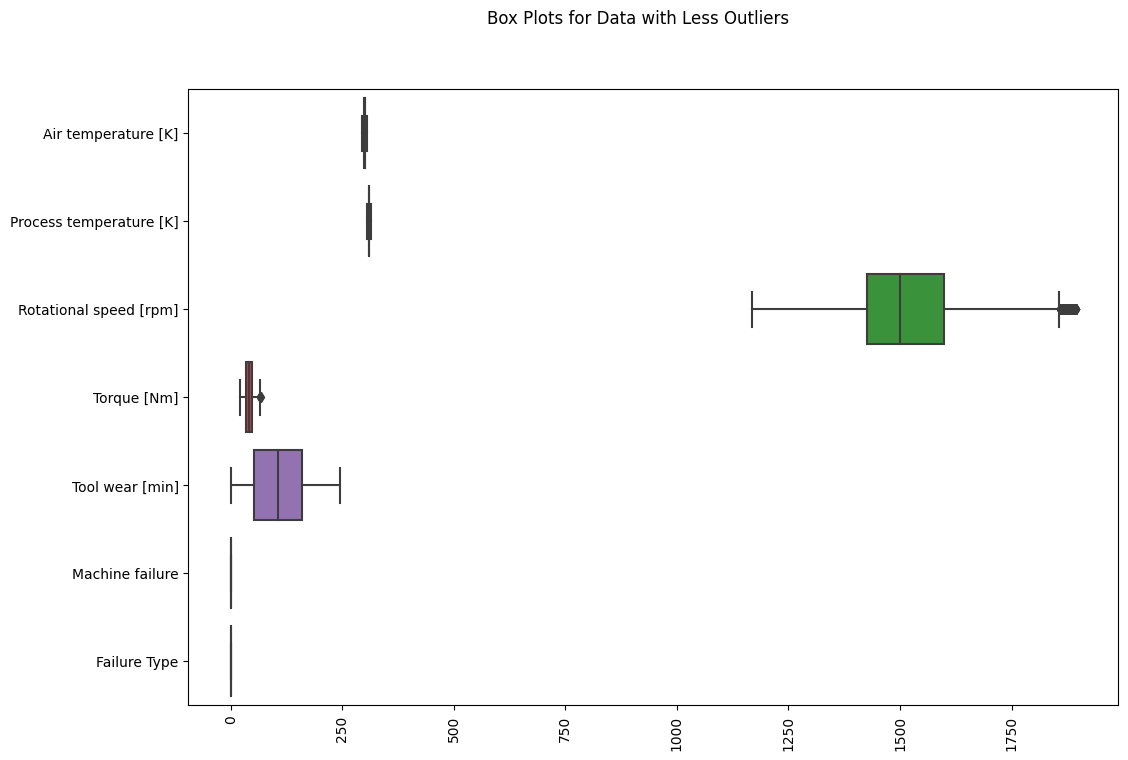

In [180]:
print("\n\nBox Plots for Data without Outliers\n\n")
# Create box plots for data without outliers
plt.figure(figsize=(12, 8))
plt.suptitle("Box Plots for Data with Less Outliers")
sns.boxplot(data=data_no_outliers, orient='h')
plt.xticks(rotation=90)
plt.show()

In [181]:
# Checking shape of the dataset after removing outliers and irrelevant features
print("Number of instances & columns: ", data_no_outliers.shape)

Number of instances & columns:  (9256, 8)


In [182]:
# Examine the columns
print("Columns present in the dataset:")
print(data_no_outliers.columns)

Columns present in the dataset:
Index(['Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'Failure Type'],
      dtype='object')


# **c. Convert any categorical features to numerical features using one-hot encoding**

In [183]:
# Select the categorical features to encode
categorical_features = ['Type']

# Perform one-hot encoding using pandas' get_dummies() function
encoded_df = pd.get_dummies(data, columns=categorical_features)

# Display the data with one-hot encoding 
print("Data with One-Hot Encoding:")
# Print the encoded dataframe head
print(encoded_df.head())


Data with One-Hot Encoding:
   Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0                298.1                    308.6                    1551   
1                298.2                    308.7                    1408   
2                298.1                    308.5                    1498   
3                298.2                    308.6                    1433   
4                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  Machine failure  Failure Type  Type_H  \
0         42.8                0                0             0       0   
1         46.3                3                0             0       0   
2         49.4                5                0             0       0   
3         39.5                7                0             0       0   
4         40.0                9                0             0       0   

   Type_L  Type_M  
0       0       1  
1       1       0  
2       1       

In [184]:
# Examine the columns
print("Columns in the dataset after dropping the irrelevant and after performing One-hot encoding:")
encoded_df.columns

Columns in the dataset after dropping the irrelevant and after performing One-hot encoding:


Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'Failure Type', 'Type_H', 'Type_L', 'Type_M'],
      dtype='object')

In [185]:
# Checking shape of the dataset 
print("Number of instances & columns: ", encoded_df.shape)

Number of instances & columns:  (10000, 10)


In [186]:
# Print the dataframe sample before scaling
print(encoded_df.head(5))

   Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0                298.1                    308.6                    1551   
1                298.2                    308.7                    1408   
2                298.1                    308.5                    1498   
3                298.2                    308.6                    1433   
4                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  Machine failure  Failure Type  Type_H  \
0         42.8                0                0             0       0   
1         46.3                3                0             0       0   
2         49.4                5                0             0       0   
3         39.5                7                0             0       0   
4         40.0                9                0             0       0   

   Type_L  Type_M  
0       0       1  
1       1       0  
2       1       0  
3       1       0  
4   

In [187]:
# # Feature scaling 
# scaler = MinMaxScaler()
# cols_to_scale = ['Air temperature [K]','Process temperature [K]',	'Rotational speed [rpm]',	'Torque [Nm]',	'Tool wear [min]']

# encoded_df[cols_to_scale] = scaler.fit_transform(encoded_df[cols_to_scale])

In [188]:
# Print the dataframe sample after scaling
print(encoded_df.head(5))

   Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0                298.1                    308.6                    1551   
1                298.2                    308.7                    1408   
2                298.1                    308.5                    1498   
3                298.2                    308.6                    1433   
4                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  Machine failure  Failure Type  Type_H  \
0         42.8                0                0             0       0   
1         46.3                3                0             0       0   
2         49.4                5                0             0       0   
3         39.5                7                0             0       0   
4         40.0                9                0             0       0   

   Type_L  Type_M  
0       0       1  
1       1       0  
2       1       0  
3       1       0  
4   

In [189]:
# Examine the columns and their data types after preprocessing steps
print(encoded_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Air temperature [K]      10000 non-null  float64
 1   Process temperature [K]  10000 non-null  float64
 2   Rotational speed [rpm]   10000 non-null  int64  
 3   Torque [Nm]              10000 non-null  float64
 4   Tool wear [min]          10000 non-null  int64  
 5   Machine failure          10000 non-null  int64  
 6   Failure Type             10000 non-null  int64  
 7   Type_H                   10000 non-null  uint8  
 8   Type_L                   10000 non-null  uint8  
 9   Type_M                   10000 non-null  uint8  
dtypes: float64(3), int64(4), uint8(3)
memory usage: 576.3 KB
None


In [190]:
# Checking final shape of the dataset
encoded_df.shape

(10000, 10)

# ***2. Feature Engineering and Selection:***

## **a.  Create new features from the existing features**

In [191]:

# Feature engineering :

#Calculate the difference between air and process temperature
encoded_df['temp_diff'] = encoded_df['Air temperature [K]'] - encoded_df['Process temperature [K]']

# Calculate the percentage of tool wear
encoded_df['tool_wear_perc'] = (encoded_df['Tool wear [min]'] / encoded_df['Tool wear [min]'].max()) * 100

#Calculate the ratio of torque to rotational speed
# data_preprocessed['torque_to_speed'] = data_preprocessed['Torque [Nm]'] / data_preprocessed['Rotational speed [rpm]']


#Calculate the product of torque and rotational speed (power)
encoded_df['power'] = encoded_df['Torque [Nm]'] * encoded_df['Rotational speed [rpm]']


# Display the new features
print(encoded_df.head())


   Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0                298.1                    308.6                    1551   
1                298.2                    308.7                    1408   
2                298.1                    308.5                    1498   
3                298.2                    308.6                    1433   
4                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  Machine failure  Failure Type  Type_H  \
0         42.8                0                0             0       0   
1         46.3                3                0             0       0   
2         49.4                5                0             0       0   
3         39.5                7                0             0       0   
4         40.0                9                0             0       0   

   Type_L  Type_M  temp_diff  tool_wear_perc    power  
0       0       1      -10.5        0.000000  66

In [192]:
# Check if a column contains infinity
if np.isinf(encoded_df['power']).any():
    print("The column contains infinity values.")

# Check if a column contains very large values
threshold = 1e9  # Define the threshold for very large values
if (encoded_df['power'] > threshold).any():
    print("The column contains very large values.")


In [193]:
# Examine the columns
print("Columns in the dataset:")
encoded_df.info()

Columns in the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Air temperature [K]      10000 non-null  float64
 1   Process temperature [K]  10000 non-null  float64
 2   Rotational speed [rpm]   10000 non-null  int64  
 3   Torque [Nm]              10000 non-null  float64
 4   Tool wear [min]          10000 non-null  int64  
 5   Machine failure          10000 non-null  int64  
 6   Failure Type             10000 non-null  int64  
 7   Type_H                   10000 non-null  uint8  
 8   Type_L                   10000 non-null  uint8  
 9   Type_M                   10000 non-null  uint8  
 10  temp_diff                10000 non-null  float64
 11  tool_wear_perc           10000 non-null  float64
 12  power                    10000 non-null  float64
dtypes: float64(6), int64(4), uint8(3)
memory usage: 810.7

In [194]:
# Checking final shape of the dataset
encoded_df.shape

(10000, 13)

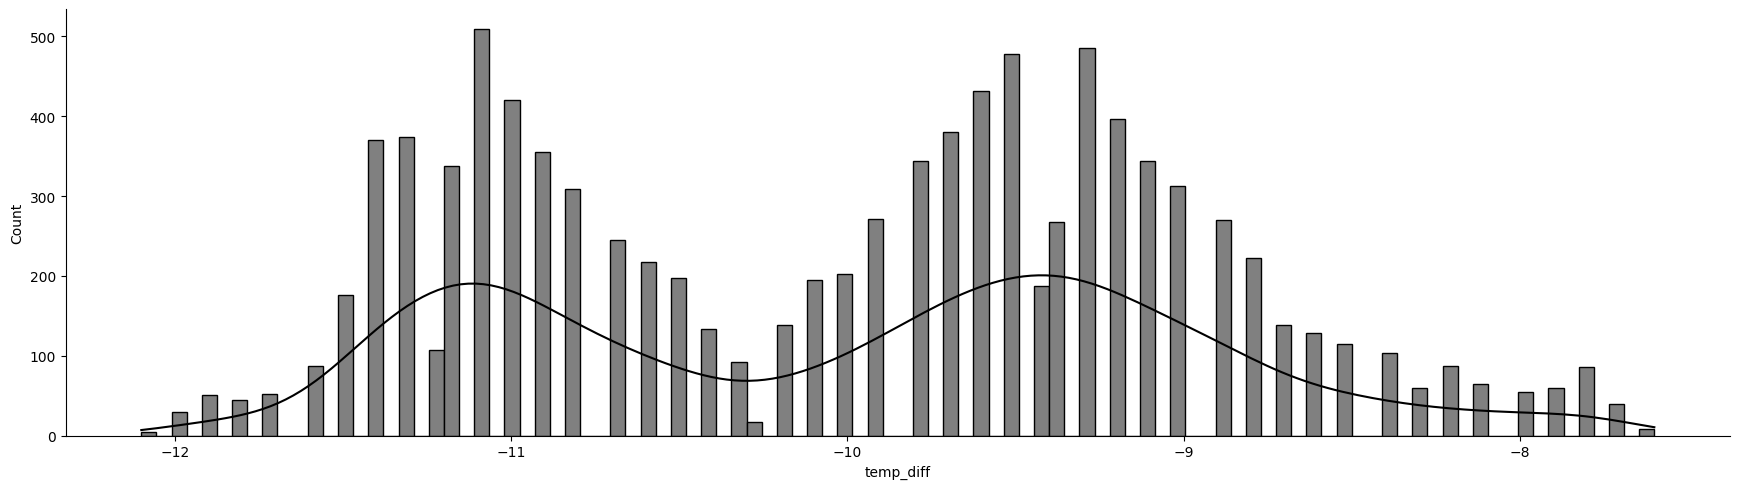

In [195]:
sns.displot(data=encoded_df, x="temp_diff", kde=True, bins = 100,color = "black", facecolor = "grey",height = 5, aspect = 3.5);

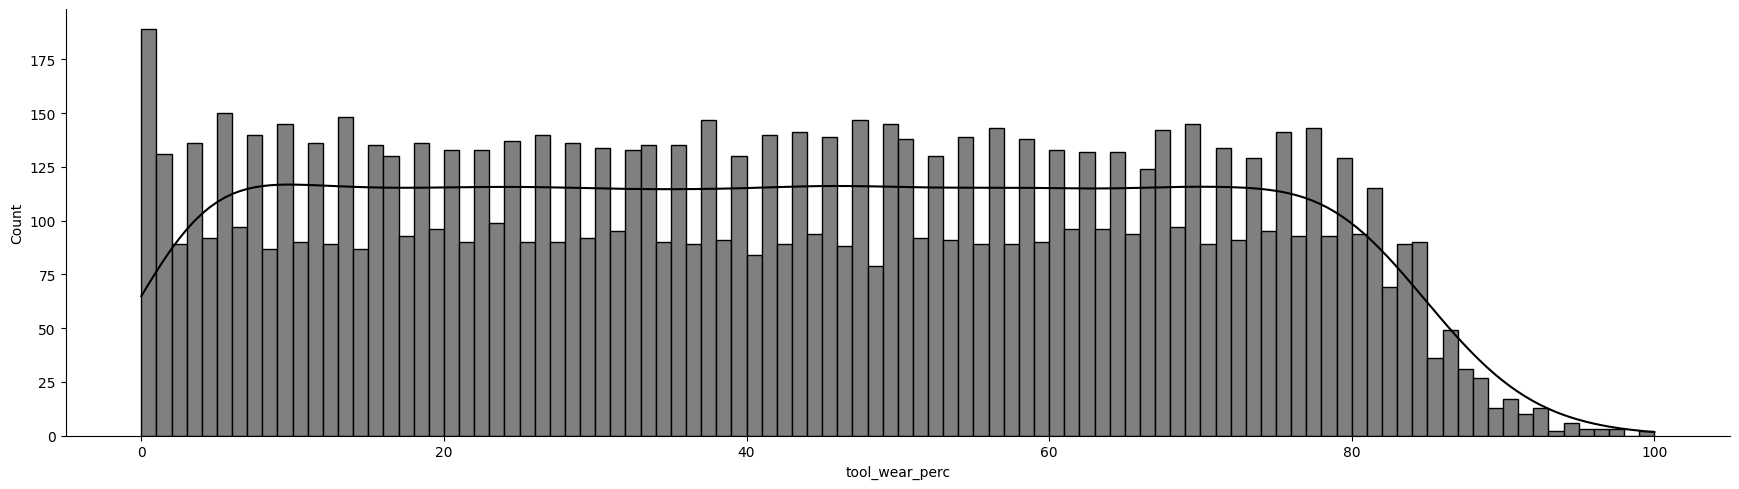

In [196]:
sns.displot(data=encoded_df, x="tool_wear_perc", kde=True, bins = 100,color = "black", facecolor = "grey",height = 5, aspect = 3.5);

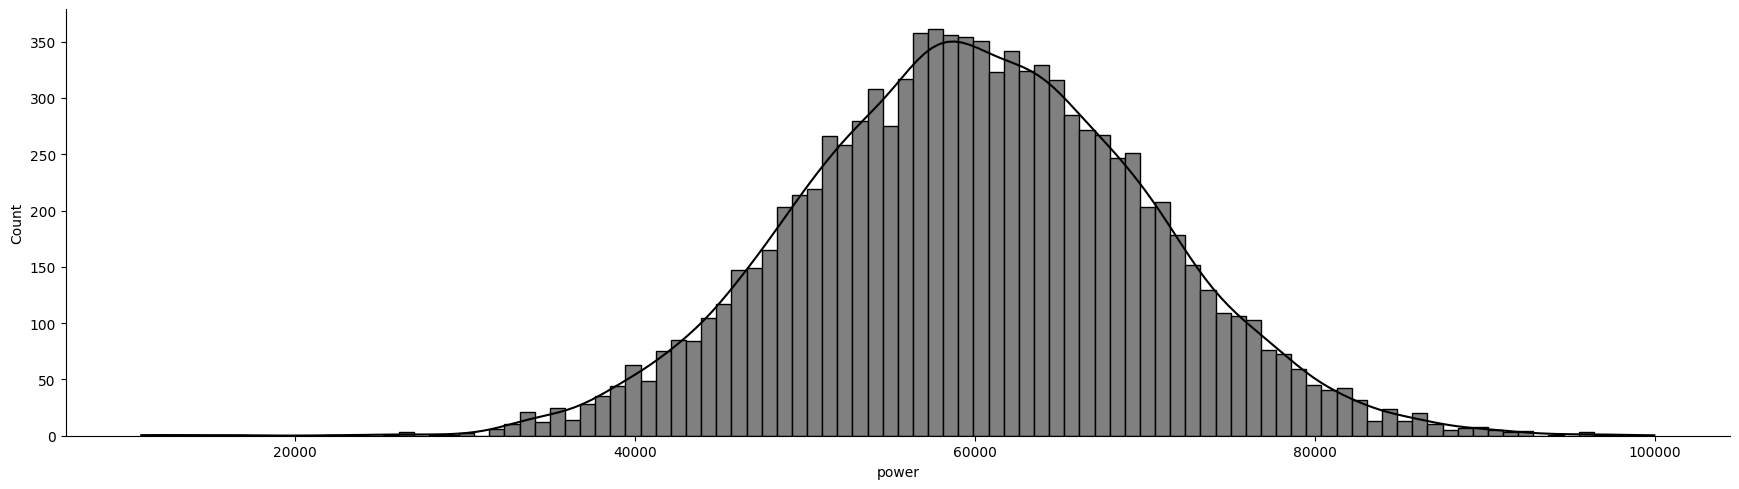

In [197]:
sns.displot(data=encoded_df, x="power", kde=True, bins = 100,color = "black", facecolor = "grey",height = 5, aspect = 3.5);

## **b. Using correlation analysis to identify the most important features.**

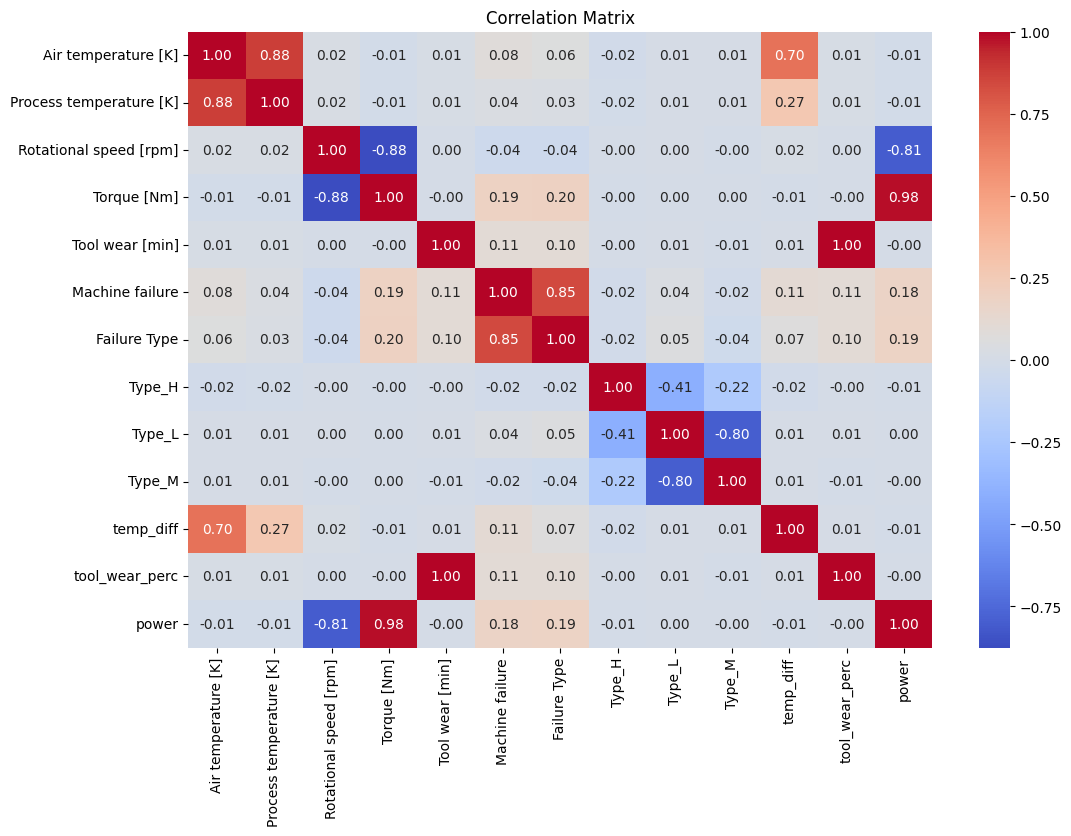

In [198]:
# Compute the correlation matrix
corr_matrix = encoded_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [199]:
# Select the features with a high correlation with the target variable
corr_threshold = 0.03
important_features = list(corr_matrix[(corr_matrix['Machine failure']) > corr_threshold].index)

# Drop the target variable from the list of important features
important_features.remove('Machine failure')

# Subset the dataset to include only the important features
selected_data = encoded_df[important_features + ['Machine failure']]

print("Important features given by correlation analysis are: ",important_features)

Important features given by correlation analysis are:  ['Air temperature [K]', 'Process temperature [K]', 'Torque [Nm]', 'Tool wear [min]', 'Failure Type', 'Type_L', 'temp_diff', 'tool_wear_perc', 'power']


In [200]:

#Dropping unnecessary column as identified above
encoded_df = encoded_df.drop(['Type_H','Type_L', 'Type_M', 'power', 'Rotational speed [rpm]'],axis=1)    #these columns are of no use as they are not a deciding factor to our Target

#we have to drop this feature as well because this feature needs to have the full view of the dataset, which is not possible at runtime
encoded_df = encoded_df.drop(['tool_wear_perc'],axis=1)  

#Dataset after dropping the unnecessary columns 
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Air temperature [K]      10000 non-null  float64
 1   Process temperature [K]  10000 non-null  float64
 2   Torque [Nm]              10000 non-null  float64
 3   Tool wear [min]          10000 non-null  int64  
 4   Machine failure          10000 non-null  int64  
 5   Failure Type             10000 non-null  int64  
 6   temp_diff                10000 non-null  float64
dtypes: float64(4), int64(3)
memory usage: 547.0 KB


# **Split the data into training and testing sets.**

In [201]:
# Split the data into features and target
X = encoded_df.drop(['Machine failure', 'Failure Type'], axis=1)
y_failure = encoded_df['Machine failure']
y_type = encoded_df[['Failure Type']]

print(X)
print(y_failure)
print(y_type)

# Split the data into training and testing sets
X_train, X_test, y_train_failure, y_test_failure, y_train_type, y_test_type = train_test_split(X, y_failure, y_type, test_size=0.2, random_state=42)


# Print the shapes of the resulting datasets
print("Training set shape for Machine failure prediction:", X_train.shape, y_train_failure.shape)
print("Testing set shape for Machine failure prediction:", X_test.shape, y_test_failure.shape)
print("Training set shape for Machine Failure Type prediction:", X_train.shape, y_train_type.shape)
print("Testing set shape for Machine Failure Type prediction:", X_test.shape, y_test_type.shape)

      Air temperature [K]  Process temperature [K]  Torque [Nm]  \
0                   298.1                    308.6         42.8   
1                   298.2                    308.7         46.3   
2                   298.1                    308.5         49.4   
3                   298.2                    308.6         39.5   
4                   298.2                    308.7         40.0   
...                   ...                      ...          ...   
9995                298.8                    308.4         29.5   
9996                298.9                    308.4         31.8   
9997                299.0                    308.6         33.4   
9998                299.0                    308.7         48.5   
9999                299.0                    308.7         40.2   

      Tool wear [min]  temp_diff  
0                   0      -10.5  
1                   3      -10.5  
2                   5      -10.4  
3                   7      -10.4  
4                   

In [202]:
# Performing Jarque-Bera test for normality
stats, p = jarque_bera(encoded_df)

if p > 0.05:
    print('The data is Normally distributed.')
else:
    print('The data is not normally distributed.')

The data is not normally distributed.


In [203]:
# Computing the Durbin-Watson test statistic
dw_statistic = np.apply_along_axis(durbin_watson, 0, X)

# Checking if the data is linear
if np.all(dw_statistic > 1.5) and np.all(dw_statistic < 2.5):
    print("The data is linear.")
else:
    print("The data is non-linear.")

The data is non-linear.


# **3. Model Selection and Training:**

Considering the problem statement involves predicting two different things, we can use two separate models for each prediction. For predicting machine failure, we can use a binary classification model such as Logistic Regression, Decision Tree, Random Forest, or Support Vector Machines (SVM), and for predicting the type of failure, we can use a multi-class classification model such as Random Forest or Neural Networks. Let's try out different combinations:

**Lets first explore models for machine failure prediction**

SVM (Support Vector Machines)

In [148]:
#SVM for machine failure prediction
# Create and train the SVM model
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train_failure)

# Make predictions on training and testing data
y_train_pred = svm_model.predict(X_train)
y_test_pred = svm_model.predict(X_test)

# Calculate accuracy, precision, recall, and F1 score
train_accuracy = accuracy_score(y_train_failure, y_train_pred) * 100
test_accuracy = accuracy_score(y_test_failure, y_test_pred) * 100
precision = precision_score(y_test_failure, y_test_pred) * 100
recall = recall_score(y_test_failure, y_test_pred) * 100
f1 = f1_score(y_test_failure, y_test_pred) * 100

# Print the results
print("Training Accuracy of SVM:", train_accuracy, "%")
print("Testing Accuracy of SVM:", test_accuracy, "%")
print("Precision of SVM:", precision, "%")
print("Recall of SVM:", recall, "%")
print("F1 Score of SVM:", f1, "%")


Training Accuracy of SVM: 96.525 %
Testing Accuracy of SVM: 96.95 %
Precision of SVM: 0.0 %
Recall of SVM: 0.0 %
F1 Score of SVM: 0.0 %


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Decision Tree Classifier

In [149]:
# Create and train the Decision Tree model
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train_failure)

# Make predictions on training and testing data
y_train_pred = dt_model.predict(X_train)
y_test_pred = dt_model.predict(X_test)

# Calculate accuracy, precision, recall, and F1 score
train_accuracy = accuracy_score(y_train_failure, y_train_pred) * 100
test_accuracy = accuracy_score(y_test_failure, y_test_pred) * 100
precision = precision_score(y_test_failure, y_test_pred) * 100
recall = recall_score(y_test_failure, y_test_pred) * 100
f1 = f1_score(y_test_failure, y_test_pred) * 100

# Print the results
print("Training Accuracy:", train_accuracy, "%")
print("Testing Accuracy:", test_accuracy, "%")
print("Precision:", precision, "%")
print("Recall:", recall, "%")
print("F1 Score:", f1, "%")

Training Accuracy: 100.0 %
Testing Accuracy: 96.2 %
Precision: 40.963855421686745 %
Recall: 55.73770491803278 %
F1 Score: 47.22222222222222 %


Logistic Regression - Best Hyperparameters

In [150]:

# # Logistic regression for machine failure prediction


# Create the Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000)

# Define the hyperparameters for grid search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
}

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(logreg_model, param_grid, cv=5)
grid_search.fit(X_train, y_train_failure)

# Get the best model with the optimized hyperparameters
best_logreg_model = grid_search.best_estimator_

# Make predictions on training and testing data
y_train_pred = best_logreg_model.predict(X_train)
y_test_pred = best_logreg_model.predict(X_test)

# Calculate accuracy, precision, recall, and F1 score
train_accuracy = accuracy_score(y_train_failure, y_train_pred) * 100
test_accuracy = accuracy_score(y_test_failure, y_test_pred) * 100
precision = precision_score(y_test_failure, y_test_pred) * 100
recall = recall_score(y_test_failure, y_test_pred) * 100
f1 = f1_score(y_test_failure, y_test_pred) * 100

# Print the results
print("Training Accuracy:", train_accuracy, "%")
print("Testing Accuracy:", test_accuracy, "%")
print("Precision:", precision, "%")
print("Recall:", recall, "%")
print("F1 Score:", f1, "%")



Training Accuracy: 96.7375 %
Testing Accuracy: 97.15 %
Precision: 100.0 %
Recall: 6.557377049180328 %
F1 Score: 12.307692307692307 %


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

Logistic Regression - after class balancing through SMOTE



---





In [151]:

# # Logistic regression for machine failure prediction

# Apply SMOTE to balance the training data for machine failure prediction
sm = SMOTE(random_state=42)
X_train_resampled, y_train_failure_resampled  = sm.fit_resample(X_train, y_train_failure)
X_test_resampled, y_test_failure_resampled = sm.fit_resample( X_test, y_test_failure)
# Create the Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000)

# Define the hyperparameters for grid search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
}

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(logreg_model, param_grid, cv=5)
grid_search.fit(X_train_resampled, y_train_failure_resampled)

# Get the best model with the optimized hyperparameters
best_logreg_model = grid_search.best_estimator_

# Make predictions on training and testing data
y_train_pred = best_logreg_model.predict(X_train_resampled)
y_test_pred = best_logreg_model.predict(X_test_resampled)

# Calculate accuracy, precision, recall, and F1 score
train_accuracy = accuracy_score(y_train_failure_resampled, y_train_pred) * 100
test_accuracy = accuracy_score(y_test_failure_resampled, y_test_pred) * 100
precision = precision_score(y_test_failure_resampled, y_test_pred) * 100
recall = recall_score(y_test_failure_resampled, y_test_pred) * 100
f1 = f1_score(y_test_failure_resampled, y_test_pred) * 100

# Print the results
print("Training Accuracy:", train_accuracy, "%")
print("Testing Accuracy:", test_accuracy, "%")
print("Precision:", precision, "%")
print("Recall:", recall, "%")
print("F1 Score:", f1, "%")



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

Training Accuracy: 78.84615384615384 %
Testing Accuracy: 76.74058793192367 %
Precision: 76.38676844783716 %
Recall: 77.4110366168128 %
F1 Score: 76.89549180327869 %


Logistic Regression - after class balancing through weights



---





In [314]:

# # Logistic regression for machine failure prediction

class_weight = {0: 1, 1: 9661/339}  # Class 0 weight = 1, Class 1 weight = ratio

# Create the Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000, class_weight=class_weight)

# Define the hyperparameters for grid search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
}

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(logreg_model, param_grid, cv=5)
grid_search.fit(X_train, y_train_failure)

# Get the best model with the optimized hyperparameters
best_logreg_model = grid_search.best_estimator_

# Make predictions on training and testing data
y_train_pred = best_logreg_model.predict(X_train)
y_test_pred = best_logreg_model.predict(X_test)

# Calculate accuracy, precision, recall, and F1 score
train_accuracy = accuracy_score(y_train_failure, y_train_pred) * 100
test_accuracy = accuracy_score(y_test_failure, y_test_pred) * 100
precision = precision_score(y_test_failure, y_test_pred) * 100
recall = recall_score(y_test_failure, y_test_pred) * 100
f1 = f1_score(y_test_failure, y_test_pred) * 100

# Print the results
print("Training Accuracy:", train_accuracy, "%")
print("Testing Accuracy:", test_accuracy, "%")
print("Precision:", precision, "%")
print("Recall:", recall, "%")
print("F1 Score:", f1, "%")



Training Accuracy: 74.0 %
Testing Accuracy: 73.85000000000001 %
Precision: 8.0 %
Recall: 72.1311475409836 %
F1 Score: 14.402618657937808 %


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

Neural Network Model

---



In [254]:

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(y_train_failure)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train_failure, epochs=100, batch_size=32, validation_data=(X_test, y_test_failure))


# Evaluate the model on training data
train_loss, train_accuracy = model.evaluate(X_train, y_train_failure, verbose=0)
print("Training Accuracy: {:.2f}%".format(train_accuracy * 100))

# Evaluate the model on testing data
test_loss, test_accuracy = model.evaluate(X_test, y_test_failure, verbose=0)
print("Testing Accuracy: {:.2f}%".format(test_accuracy * 100))

# Predict on testing data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test_failure, y_pred_classes, average='macro')
recall = recall_score(y_test_failure, y_pred_classes, average='macro')
f1 = f1_score(y_test_failure, y_pred_classes, average='macro')

print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}%".format(f1 * 100))

Epoch 1/100
250/250 [==============================] - 2s 3ms/step - loss: 0.2146 - accuracy: 0.9649 - val_loss: 0.1495 - val_accuracy: 0.9695
Epoch 2/100
250/250 [==============================] - 1s 3ms/step - loss: 0.1757 - accuracy: 0.9653 - val_loss: 0.1401 - val_accuracy: 0.9695
Epoch 3/100
250/250 [==============================] - 1s 3ms/step - loss: 0.1723 - accuracy: 0.9649 - val_loss: 0.1482 - val_accuracy: 0.9695
Epoch 4/100
250/250 [==============================] - 1s 2ms/step - loss: 0.1631 - accuracy: 0.9653 - val_loss: 0.1388 - val_accuracy: 0.9695
Epoch 5/100
250/250 [==============================] - 1s 3ms/step - loss: 0.1587 - accuracy: 0.9653 - val_loss: 0.1346 - val_accuracy: 0.9695
Epoch 6/100
250/250 [==============================] - 1s 3ms/step - loss: 0.1602 - accuracy: 0.9653 - val_loss: 0.1299 - val_accuracy: 0.9695
Epoch 7/100
250/250 [==============================] - 1s 2ms/step - loss: 0.1531 - accuracy: 0.9654 - val_loss: 0.1414 - val_accuracy: 0.9695

**Now lets explore models for machine failure type prediction**

Random Forest Classifier

In [213]:


# Create the Random Forest model with appropriate hyperparameters
model = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)

# Fit the model on the training data
model.fit(X_train, y_train_type)

# Predict on the training data
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train_type, y_train_pred)
train_precision = precision_score(y_train_type, y_train_pred, average='macro')
train_recall = recall_score(y_train_type, y_train_pred, average='macro')
train_f1 = f1_score(y_train_type, y_train_pred, average='macro')

# Predict on the testing data
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test_type, y_test_pred)
test_precision = precision_score(y_test_type, y_test_pred, average='macro')
test_recall = recall_score(y_test_type, y_test_pred, average='macro')
test_f1 = f1_score(y_test_type, y_test_pred, average='macro')

# Print the evaluation metrics
print("Training Accuracy: {:.2f}%".format(train_accuracy * 100))
print("Testing Accuracy: {:.2f}%".format(test_accuracy * 100))
print("Precision: {:.2f}%".format(test_precision * 100))
print("Recall: {:.2f}%".format(test_recall * 100))
print("F1 Score: {:.2f}%".format(test_f1 * 100))


<ipython-input-213-6d7dba58fe0a>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train_type)


Training Accuracy: 100.00%
Testing Accuracy: 97.55%
Precision: 50.55%
Recall: 46.14%
F1 Score: 47.67%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Network Model - Hyperparameter Tuning

---



In [214]:
# Define the hyperparameter grid
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'hidden_layers': [1, 2, 3],
    'neurons_per_layer': [64, 128, 256],
    'activation': ['relu', 'sigmoid']
}

# Define the model building function
def build_model(learning_rate, hidden_layers, neurons_per_layer, activation):
    model = Sequential()
    model.add(Dense(neurons_per_layer, activation=activation, input_shape=(X_train.shape[1],)))
    
    for _ in range(hidden_layers-1):
        model.add(Dense(neurons_per_layer, activation=activation))
    
    model.add(Dense(len(np.unique(y_train_type)), activation='softmax'))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Create the model
model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_model)

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_search.fit(X_train, y_train_type)

# Print the best hyperparameter combination and the corresponding validation score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Validation Score:", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test_type)
print("Testing Accuracy: {:.2f}%".format(test_accuracy * 100))

# Evaluate the best model on the training set
train_accuracy = best_model.score(X_train, y_train_type)
print("Training Accuracy: {:.2f}%".format(train_accuracy * 100))

# Predict on the test set
y_pred = best_model.predict(X_test)

# Calculate precision, recall, and F1 score on the test set
precision = precision_score(y_test_type, y_pred, average='macro')
recall = recall_score(y_test_type, y_pred, average='macro')
f1 = f1_score(y_test_type, y_pred, average='macro')

print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}%".format(f1 * 100))


<ipython-input-214-59089b57b24a>:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_model)


250/250 [==============================] - 2s 4ms/step - loss: 1.2099 - accuracy: 0.9476
Best Hyperparameters: {'activation': 'relu', 'hidden_layers': 2, 'learning_rate': 0.001, 'neurons_per_layer': 256}
Best Validation Score: 0.9651249448458353
63/63 [==============================] - 0s 2ms/step - loss: 0.6734 - accuracy: 0.9680
Testing Accuracy: 96.80%
250/250 [==============================] - 1s 2ms/step - loss: 0.4424 - accuracy: 0.9656
Training Accuracy: 96.56%
63/63 [==============================] - 0s 2ms/step
Precision: 20.33%
Recall: 17.95%
F1 Score: 18.37%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Network Model - Best hyperparameters

---



In [215]:

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(y_train_type)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train_type, epochs=100, batch_size=32, validation_data=(X_test, y_test_type))


# Evaluate the model on training data
train_loss, train_accuracy = model.evaluate(X_train, y_train_type, verbose=0)
print("Training Accuracy: {:.2f}%".format(train_accuracy * 100))

# Evaluate the model on testing data
test_loss, test_accuracy = model.evaluate(X_test, y_test_type, verbose=0)
print("Testing Accuracy: {:.2f}%".format(test_accuracy * 100))

# Predict on testing data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test_type, y_pred_classes, average='macro')
recall = recall_score(y_test_type, y_pred_classes, average='macro')
f1 = f1_score(y_test_type, y_pred_classes, average='macro')

print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}%".format(f1 * 100))

Epoch 1/100
250/250 [==============================] - 2s 4ms/step - loss: 5.7590 - accuracy: 0.9262 - val_loss: 0.4206 - val_accuracy: 0.9675
Epoch 2/100
250/250 [==============================] - 1s 3ms/step - loss: 0.2852 - accuracy: 0.9605 - val_loss: 0.4417 - val_accuracy: 0.9670
Epoch 3/100
250/250 [==============================] - 1s 4ms/step - loss: 0.3227 - accuracy: 0.9586 - val_loss: 0.3270 - val_accuracy: 0.9680
Epoch 4/100
250/250 [==============================] - 1s 5ms/step - loss: 0.3077 - accuracy: 0.9591 - val_loss: 0.2804 - val_accuracy: 0.9565
Epoch 5/100
250/250 [==============================] - 1s 5ms/step - loss: 0.2687 - accuracy: 0.9600 - val_loss: 0.1942 - val_accuracy: 0.9655
Epoch 6/100
250/250 [==============================] - 1s 3ms/step - loss: 0.2677 - accuracy: 0.9595 - val_loss: 0.2929 - val_accuracy: 0.9675
Epoch 7/100
250/250 [==============================] - 1s 3ms/step - loss: 0.2319 - accuracy: 0.9620 - val_loss: 0.5193 - val_accuracy: 0.9675

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Network Model - After SMOTE

---



In [318]:

# Create the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(len(np.unique(y_train_type)), activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Apply SMOTE to balance the training data for machine failure prediction
sm = SMOTE(random_state=42)
X_train_resampled, y_train_type_resampled  = sm.fit_resample(X_train, y_train_type)
X_test_resampled, y_test_type_resampled = sm.fit_resample( X_test, y_test_type)


# Train the model
history = model.fit(X_train_resampled, y_train_type_resampled, epochs=100, batch_size=32, validation_data=(X_test_resampled, y_test_type_resampled))

# Evaluate the model on training data
train_loss, train_accuracy = model.evaluate(X_train_resampled, y_train_type_resampled, verbose=0)
print("Training Accuracy: {:.2f}%".format(train_accuracy * 100))

# Evaluate the model on testing data
test_loss, test_accuracy = model.evaluate(X_test_resampled, y_test_type_resampled, verbose=0)
print("Testing Accuracy: {:.2f}%".format(test_accuracy * 100))

# Predict on testing data
y_pred = model.predict(X_test_resampled)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test_type_resampled, y_pred_classes, average='macro')
recall = recall_score(y_test_type_resampled, y_pred_classes, average='macro')
f1 = f1_score(y_test_type_resampled, y_pred_classes, average='macro')

print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}%".format(f1 * 100))


Epoch 1/100
1447/1447 [==============================] - 5s 3ms/step - loss: 1.0757 - accuracy: 0.6665 - val_loss: 0.9814 - val_accuracy: 0.6587
Epoch 2/100
1447/1447 [==============================] - 3s 2ms/step - loss: 0.5784 - accuracy: 0.8321 - val_loss: 0.8484 - val_accuracy: 0.7235
Epoch 3/100
1447/1447 [==============================] - 3s 2ms/step - loss: 0.4496 - accuracy: 0.8588 - val_loss: 0.8268 - val_accuracy: 0.7103
Epoch 4/100
1447/1447 [==============================] - 3s 2ms/step - loss: 0.3946 - accuracy: 0.8713 - val_loss: 0.8236 - val_accuracy: 0.7163
Epoch 5/100
1447/1447 [==============================] - 4s 3ms/step - loss: 0.3629 - accuracy: 0.8797 - val_loss: 0.8858 - val_accuracy: 0.7271
Epoch 6/100
1447/1447 [==============================] - 3s 2ms/step - loss: 0.3421 - accuracy: 0.8870 - val_loss: 1.0041 - val_accuracy: 0.7337
Epoch 7/100
1447/1447 [==============================] - 3s 2ms/step - loss: 0.3265 - accuracy: 0.8930 - val_loss: 1.0088 - val_ac

In [152]:
# Print the shapes of the resulting datasets after SMOTE
print("Training set shape for Machine failure prediction:", X_train_resampled.shape, y_train_failure_resampled.shape)
print("Testing set shape for Machine failure prediction:", X_test_resampled.shape, y_test_failure_resampled.shape)
print("Training set shape for Machine Failure Type prediction:", X_train_resampled.shape, y_train_type_resampled.shape)
print("Testing set shape for Machine Failure Type prediction:", X_test_resampled.shape, y_test_type_resampled.shape)

Training set shape for Machine failure prediction: (15444, 5) (15444,)
Testing set shape for Machine failure prediction: (3878, 5) (3878,)


NameError: ignored

*We will go with **Neural Network** model for Machine failure prediction & similarly **Neural Network** Model for Failure Type prediction.*

## **Best Model**

**Recall Score** would be important than **Precision** as a false positive may result in unnecessary maintenance, while a false negative could result in a catastrophic failure of the machine. Therefore, the cost of a false negative may be much higher than the cost of a false positive.
But we will try to find a good balance between both.

Neural Network Final Model for Machine Failure Prediction

---



In [204]:

finalmodelMF = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(y_train_failure)), activation='softmax')
])

finalmodelMF.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = finalmodelMF.fit(X_train, y_train_failure, epochs=100, batch_size=32, validation_data=(X_test, y_test_failure))


# Evaluate the model on training data
train_loss, train_accuracy = finalmodelMF.evaluate(X_train, y_train_failure, verbose=0)
print("Training Accuracy: {:.2f}%".format(train_accuracy * 100))

# Evaluate the model on testing data
test_loss, test_accuracy = finalmodelMF.evaluate(X_test, y_test_failure, verbose=0)
print("Testing Accuracy: {:.2f}%".format(test_accuracy * 100))

# Predict on testing data
y_pred = finalmodelMF.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test_failure, y_pred_classes, average='macro')
recall = recall_score(y_test_failure, y_pred_classes, average='macro')
f1 = f1_score(y_test_failure, y_pred_classes, average='macro')

print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}%".format(f1 * 100))

Epoch 1/100
250/250 [==============================] - 2s 4ms/step - loss: 0.6646 - accuracy: 0.9509 - val_loss: 0.1316 - val_accuracy: 0.9595
Epoch 2/100
250/250 [==============================] - 2s 7ms/step - loss: 0.2986 - accuracy: 0.9519 - val_loss: 0.1859 - val_accuracy: 0.9695
Epoch 3/100
250/250 [==============================] - 2s 7ms/step - loss: 0.2107 - accuracy: 0.9605 - val_loss: 0.5513 - val_accuracy: 0.9695
Epoch 4/100
250/250 [==============================] - 1s 5ms/step - loss: 0.2050 - accuracy: 0.9585 - val_loss: 0.1193 - val_accuracy: 0.9695
Epoch 5/100
250/250 [==============================] - 1s 6ms/step - loss: 0.2026 - accuracy: 0.9582 - val_loss: 0.1228 - val_accuracy: 0.9680
Epoch 6/100
250/250 [==============================] - 1s 5ms/step - loss: 0.2359 - accuracy: 0.9549 - val_loss: 0.2514 - val_accuracy: 0.9695
Epoch 7/100
250/250 [==============================] - 1s 5ms/step - loss: 0.1895 - accuracy: 0.9582 - val_loss: 0.1379 - val_accuracy: 0.9695

Neural Network Final Model for Machine Failure Type Prediction

---



In [205]:

finalmodelMT = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(y_train_type)), activation='softmax')
])

finalmodelMT.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = finalmodelMT.fit(X_train, y_train_type, epochs=100, batch_size=32, validation_data=(X_test, y_test_type))


# Evaluate the model on training data
train_loss, train_accuracy = finalmodelMT.evaluate(X_train, y_train_type, verbose=0)
print("Training Accuracy: {:.2f}%".format(train_accuracy * 100))

# Evaluate the model on testing data
test_loss, test_accuracy = finalmodelMT.evaluate(X_test, y_test_type, verbose=0)
print("Testing Accuracy: {:.2f}%".format(test_accuracy * 100))

# Predict on testing data
y_pred = finalmodelMT.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test_type, y_pred_classes, average='macro')
recall = recall_score(y_test_type, y_pred_classes, average='macro')
f1 = f1_score(y_test_type, y_pred_classes, average='macro')

print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}%".format(f1 * 100))

Epoch 1/100
250/250 [==============================] - 2s 3ms/step - loss: 0.4933 - accuracy: 0.9574 - val_loss: 0.2337 - val_accuracy: 0.9675
Epoch 2/100
250/250 [==============================] - 1s 2ms/step - loss: 0.2874 - accuracy: 0.9589 - val_loss: 0.2695 - val_accuracy: 0.9680
Epoch 3/100
250/250 [==============================] - 1s 3ms/step - loss: 0.2380 - accuracy: 0.9611 - val_loss: 0.2435 - val_accuracy: 0.9590
Epoch 4/100
250/250 [==============================] - 1s 3ms/step - loss: 0.2279 - accuracy: 0.9607 - val_loss: 0.1640 - val_accuracy: 0.9655
Epoch 5/100
250/250 [==============================] - 1s 2ms/step - loss: 0.1924 - accuracy: 0.9638 - val_loss: 0.1702 - val_accuracy: 0.9680
Epoch 6/100
250/250 [==============================] - 1s 2ms/step - loss: 0.1918 - accuracy: 0.9635 - val_loss: 0.1840 - val_accuracy: 0.9675
Epoch 7/100
250/250 [==============================] - 1s 2ms/step - loss: 0.1955 - accuracy: 0.9629 - val_loss: 0.1413 - val_accuracy: 0.9700

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [212]:
data = [[298.1, 308.6, 42.8, 0, -10.5]]
prediction = finalmodelMT.predict(data)

predicted_class = np.argmax(prediction)

print(predicted_class)

1/1 [==============================] - 1s 508ms/step
0


### **Model Deployment**

---



In [206]:
finalmodelMF.save('machine_failure_prediction_model.h5')

In [207]:
finalmodelMT.save('machine_failure_type_prediction_model.h5')